In [1]:
import argparse
import os
import sys
import numpy as np

import torch
import matplotlib.pyplot as plt     # type: ignore

things_stim_path = '/user_data/mmhender/stimuli/things/'
save_stim_path = '/user_data/mmhender/stimuli/featsynth/images_v1'
texture_synth_root = os.path.dirname(os.getcwd())

texture_synth_root

sys.path.append(os.path.join(texture_synth_root, 'code'))

import utilities
import model_spatial
import optimize
import pandas as pd
import PIL
import time
import things_utils

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


/home/mmhender/.local/lib/python3.7/site-packages/torch/cuda/__init__.py:83: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10000). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
class a:
    def __init__(self, n_ims_do=10):
        self.n_ims_do = n_ims_do

args = a(1)
args

concepts_filename = os.path.join(things_stim_path, 'concepts_use.npy')
concepts_use = np.load(concepts_filename,allow_pickle=True).item()
categ_names = concepts_use['categ_names']
concept_names_subsample = concepts_use['concept_names_subsample']
image_names = concepts_use['image_names']
concept_ids_subsample = concepts_use['concept_ids_subsample']
n_categ = len(categ_names)
n_conc_each = len(concept_names_subsample[0])

categ_process = np.arange(n_categ)
conc_process = np.arange(n_conc_each)
ims_process = np.arange(args.n_ims_do)

ca = 0; categ_ind = categ_process[ca]
categ = categ_names[categ_ind]
co = 0; conc_ind = conc_process[co]
conc = concept_names_subsample[categ_ind][conc_ind]
            
ii = ims_process[0]

target_image_filename = things_utils.get_filename(categ, conc, ii)

print('\nCATEG %d of %d, IMAGE %d\n'%(ca, len(categ_process), ii))
print('processing target image %s'%target_image_filename)

name = target_image_filename.split('/')[-1].split('.jpg')[0]
                

model_path = os.path.join(texture_synth_root, 'models','VGG19_normalized_avg_pool_pytorch')

args.lr = 1.0
args.max_iter = 20
args.checkpoint_every = 1
args.debug=True

args.n_steps = 20
# if args.debug:
#     args.n_steps = 1
args.rndseed = None

args.which_grid = 5
args.n_grid_eachside=1
args.do_sqrt = True


CATEG 0 of 21, IMAGE 0

processing target image /user_data/mmhender/stimuli/things/Images/toucan/toucan_01b.jpg


In [3]:
layer_names_uppercase = ['Conv1','MaxPool1','MaxPool2','MaxPool3','MaxPool4']
n_layers = len(layer_names_uppercase)
overlap_each_layer = []
for ll in range(n_layers):

    fn = os.path.join(texture_synth_root,'grid_overlap','vgg19_gridoverlap_grid%d_%dx%d_%s.npy'%(args.which_grid,
                                                                           args.n_grid_eachside, 
                                                                    args.n_grid_eachside, 
                                                                    layer_names_uppercase[ll]))
    print('loading overlap from %s'%fn)
    overlap = np.load(fn)
    overlap_each_layer.append(overlap)

loading overlap from /user_data/mmhender/featsynth/texture_synthesis/grid_overlap/vgg19_gridoverlap_grid5_1x1_Conv1.npy
loading overlap from /user_data/mmhender/featsynth/texture_synthesis/grid_overlap/vgg19_gridoverlap_grid5_1x1_MaxPool1.npy
loading overlap from /user_data/mmhender/featsynth/texture_synthesis/grid_overlap/vgg19_gridoverlap_grid5_1x1_MaxPool2.npy
loading overlap from /user_data/mmhender/featsynth/texture_synthesis/grid_overlap/vgg19_gridoverlap_grid5_1x1_MaxPool3.npy
loading overlap from /user_data/mmhender/featsynth/texture_synthesis/grid_overlap/vgg19_gridoverlap_grid5_1x1_MaxPool4.npy


In [ ]:
target_image = utilities.preprocess_image(
                    utilities.load_image(target_image_filename)
                )

In [ ]:
target_image_postproc = utilities.postprocess_image(
                        target_image, utilities.load_image(target_image_filename)
                    )

In [ ]:
important_layers = ['relu1_1', 'pool1','pool2','pool3','pool4']

layers_do = [1,2,3,4]

ll = 1;

layers_match = important_layers[0:ll+1]
spatial_weights_use = overlap_each_layer[0:ll+1]
print('making texture for layers:')
print(layers_match)

making texture for layers:
['relu1_1', 'pool1']


In [ ]:
noise_levels = [0, 0.001, 0.01, 0.05]
# noise_levels = [0, 0.05, 0.10, 0.20]
# nl = np.array([10, 2])
# noise_levels = [n*nl for n in [0, 0.05, 0.10, 0.20]]
# noise_levels

In [10]:
final_ims = []

for nn, noise in enumerate(noise_levels):

    print(nn, noise)
    
    net = model_spatial.Model(model_path, device, target_image, \
                              important_layers=layers_match, \
                              spatial_weights_list = spatial_weights_use, 
                              do_sqrt = args.do_sqrt, 
                              add_noise = True, 
                              noise_levels = [noise])
    
    optimizer = optimize.Optimizer(net, args)
    result = optimizer.optimize()
    
    final_image = utilities.postprocess_image(
                        result, utilities.load_image(target_image_filename)
                    )
    
    final_ims.append(final_image)

0 0
[0]
torch.Size([1, 64, 256, 256])
tensor([10.1477,  0.0000])
torch.Size([1, 64, 128, 128])
tensor([2.2131, 1.3293])
tensor([[0.0231, 0.0026, 0.0042,  ..., 0.0085, 0.0090, 0.0111],
        [0.0026, 0.0137, 0.0132,  ..., 0.0002, 0.0034, 0.0076],
        [0.0042, 0.0132, 0.0157,  ..., 0.0002, 0.0051, 0.0113],
        ...,
        [0.0085, 0.0002, 0.0002,  ..., 0.0513, 0.0062, 0.0017],
        [0.0090, 0.0034, 0.0051,  ..., 0.0062, 0.0296, 0.0176],
        [0.0111, 0.0076, 0.0113,  ..., 0.0017, 0.0176, 0.0232]])
step: 1, loss: 72426600.0 (1.90s)
step: 2, loss: 8557956.0 (1.80s)
step: 3, loss: 1006469.375 (1.90s)
step: 4, loss: 218499.75 (1.77s)
step: 5, loss: 81929.3671875 (1.71s)
step: 6, loss: 41448.8125 (1.78s)
step: 7, loss: 24144.51171875 (1.82s)
step: 8, loss: 15714.3447265625 (1.78s)
step: 9, loss: 10590.95703125 (1.77s)
step: 10, loss: 7409.025390625 (1.61s)
step: 11, loss: 5490.5087890625 (1.85s)
step: 12, loss: 4140.6640625 (1.74s)
step: 13, loss: 3215.2705078125 (1.83s)
step

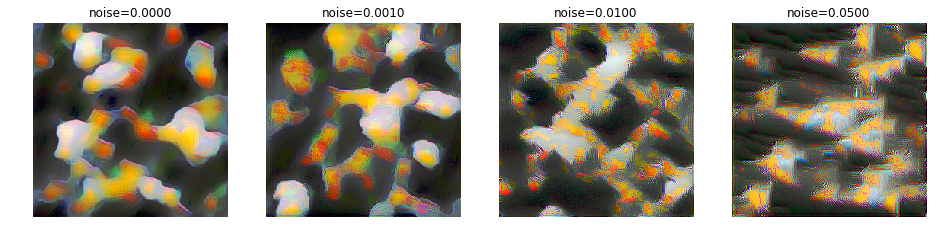

In [12]:

plt.figure(figsize=(16,4))

for nn, noise in enumerate(noise_levels):
    
    plt.subplot(1,4,nn+1)
    plt.title('noise=%.4f'%noise)
    
    plt.imshow(final_ims[nn])
    
    plt.axis('off')

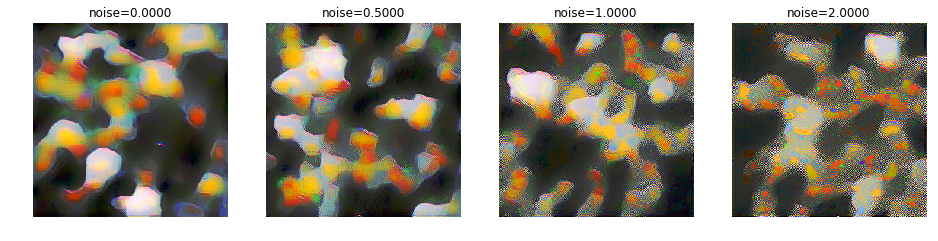

In [173]:

plt.figure(figsize=(16,4))

for nn, noise in enumerate(noise_levels):
    
    plt.subplot(1,4,nn+1)
    plt.title('noise=%.4f'%noise[0])
    
    plt.imshow(final_ims[nn])
    
    plt.axis('off')

In [ ]:
plt.figure(figsize=(16,4))

for nn, noise in enumerate(noise_levels):
    
    plt.subplot(1,4,nn+1)
    plt.title('noise=%.4f'%noise[0])
    
    plt.imshow(final_ims[nn])
    
    plt.axis('off')

In [154]:
d = np.reshape(np.array(target_image_postproc.getdata()), \
               [target_image_postproc.size[0], target_image_postproc.size[1], 3]).astype(np.uint8)
# n = np.random.normal(255/2, 255/8, d.shape)
n = np.random.normal(np.mean(d), 255/2, d.shape)

# n = np.random.normal(255/2, 0.00, d.shape)

d_noisy = d + n

d_noisy = np.minimum(np.maximum(d_noisy, 1), 255)

d_noisy = d_noisy.astype(np.uint8)

im_orig = PIL.Image.fromarray(d)
im_noisy = PIL.Image.fromarray(d_noisy)

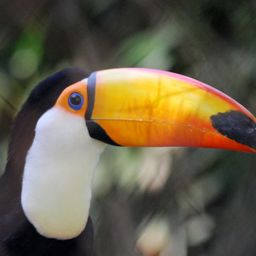

In [155]:
im_orig

In [169]:
noise_levels = [0, 255/10, 255/4, 255/2]

orig = final_ims[0]
d = np.reshape(np.array(orig.getdata()), \
               [orig.size[0], orig.size[1], 3]).astype(np.uint8)
# n = np.random.normal(255/2, 255/8, d.shape)

ims_noisy = []

for noise in noise_levels:
        
    n = np.random.normal(0, noise, d.shape)

    # n = np.random.normal(255/2, 0.00, d.shape)

    d_noisy = d + n

    d_noisy = np.minimum(np.maximum(d_noisy, 1), 255)

    d_noisy = d_noisy.astype(np.uint8)

#     im_orig = PIL.Image.fromarray(d)
    im_noisy = PIL.Image.fromarray(d_noisy)
    
    ims_noisy.append(im_noisy)

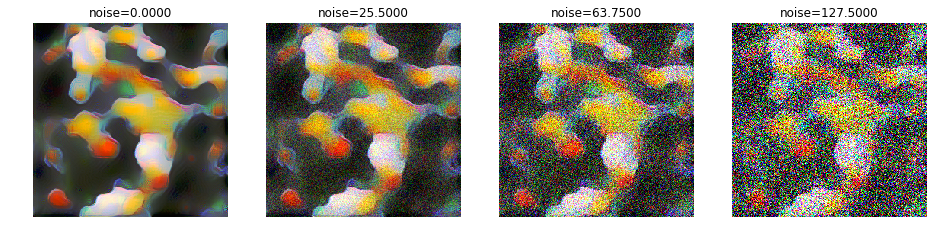

In [170]:
plt.figure(figsize=(16,4))

for nn, noise in enumerate(noise_levels):
    
    plt.subplot(1,4,nn+1)
    plt.title('noise=%.4f'%noise)
    
    plt.imshow(ims_noisy[nn])
    
    plt.axis('off')

(array([3.2000e+01, 7.0900e+02, 6.4010e+03, 2.8554e+04, 6.0208e+04,
        6.1936e+04, 3.0760e+04, 7.1920e+03, 7.8500e+02, 3.1000e+01]),
 array([-14.31545723,  13.864763  ,  42.04498323,  70.22520345,
         98.40542368, 126.58564391, 154.76586414, 182.94608437,
        211.1263046 , 239.30652482, 267.48674505]),
 <a list of 10 Patch objects>)

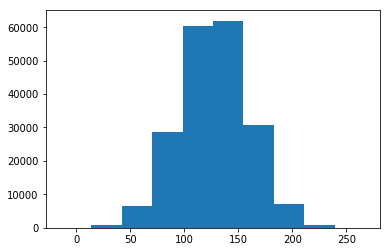

In [37]:
n = np.random.normal(255/2, 255/8, d.shape)
plt.figure()
plt.hist(n.ravel())

In [54]:
n = np.minimum(np.maximum(np.random.normal(255/2, 255/8, d.shape), 1), 254).astype(np.int8)

d_noisy = d + n
im_noisy = PIL.Image.fromarray(d_noisy)

TypeError: Cannot handle this data type

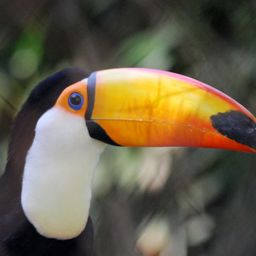

In [137]:
target_image_postproc

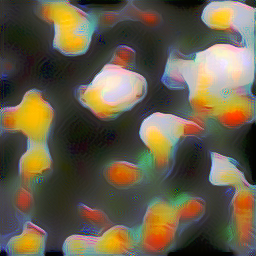

In [18]:
final_image

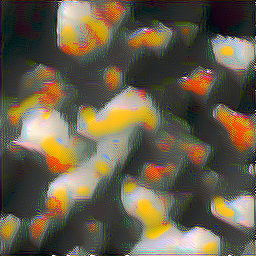

In [14]:
final_image

In [7]:
# noise_level = 0.01

target_gram_matrices = net.gram_loss_hook.target_gram_matrices

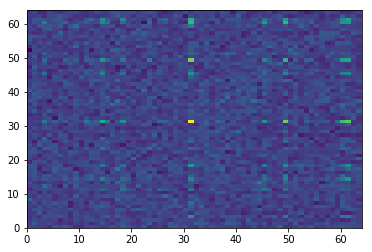

In [8]:
plt.figure()
plt.pcolormesh(target_gram_matrices[1])

In [100]:
noise_add = [torch.randn(m.shape) * noise_level for m in target_gram_matrices]
target_gram_matrices = [m + n for m, n in zip(target_gram_matrices, noise_add)]
        

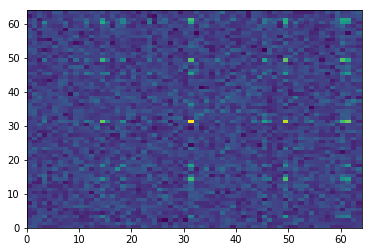

In [101]:
plt.figure()
plt.pcolormesh(target_gram_matrices[1])

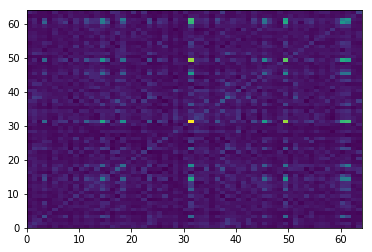

In [70]:
m = net.gram_loss_hook.target_gram_matrices[1]
import matplotlib.pyplot
plt.figure()
plt.pcolormesh(m)

In [71]:
m.shape

torch.Size([64, 64])

In [80]:
r = torch.randn(m.shape) * 0.10

In [82]:
torch.var(r)

tensor(0.0103)

In [61]:
[torch.all(sw==1) for sw in net.spatial_weights_list]


[tensor(True), tensor(True)]